# COMP90051 Project 2

In [1]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## 1. Implementing ε-Greedy and UCB

In [2]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [3]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        #define parameters
        assert narms > 1, "number of arms should be larger than 1"
        self.narms = narms
        assert 0 <= epsilon <= 1, "epsilon should be between 0 and 1"
        self.epsilon = epsilon
        self.Q0 = Q0
        self.mab = [] # internal state of the MAB, consist of
                      # [round, accumulated reward, estimated Value] of all arms
        # initialize mab
        for i in range(self.narms):
            self.mab.append([0,0,self.Q0])
        
    def play(self, tround, context=None):
        tie_list = [] # list to hold all best arms
        
        # choose wheter to exploit or explore
        if(np.random.uniform() > self.epsilon):
            # exploit the best arm
            mab_array = np.array(self.mab)
            Q = np.amax(mab_array[:, [2]])
            # find all arms with the best estimated reward
            for i in range(len(self.mab)):
                if(self.mab[i][2] == Q):
                    tie_list.append(i + 1)
            # tie breaking randomly
            random_index = np.random.randint(len(tie_list))
            return tie_list[random_index]
        else:
            #explore by choosing a random arm uniformly
            random_index = np.random.randint(self.narms) + 1
            return random_index
        
    def update(self, arm, reward, context=None):
        arm = arm - 1
        # update round
        self.mab[arm][0] += 1
        # update reward
        self.mab[arm][1] += reward
        # update estimated value
        self.mab[arm][2] = float(self.mab[arm][1])/float(self.mab[arm][0])
    

In [4]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        #define parameters
        assert narms > 1, "number of arms should be larger than 1"
        self.narms = narms
        assert rho > 0, "real explore-exploit parameter should be larger than 0"
        self.rho = rho
        self.Q0 = Q0
        self.mab = [] # internal state of the MAB, consist of
                      # [round, accumulated reward, estimated Value] of all arms
        # initialize MAB
        for i in range(self.narms):
            self.mab.append([0,0,self.Q0])
    
    def play(self, tround, context=None):
        tie_list = [] # list to hold all best arms
        
        # update estimated value with tround
        for i in range(len(self.mab)):
            Nt = self.mab[i][0]
            if (Nt != 0): # do not update initial state
                ut = float(self.mab[i][1]) / float(Nt)
                self.mab[i][2] = ut + np.sqrt((self.rho * np.log(tround)) / float(Nt))

        # exploit the best arm
        mab_array = np.array(self.mab)
        Q = np.amax(mab_array[:, [2]])
        # find all arms with the best estimated reward
        for i in range(len(self.mab)):
            if (self.mab[i][2] == Q):
                tie_list.append(i + 1)
        # tie breaking randomly
        random_index = np.random.randint(len(tie_list))
        return tie_list[random_index]
        
    def update(self, arm, reward, context=None):
        arm = arm - 1
        # update round
        self.mab[arm][0] += 1
        # update reward
        self.mab[arm][1] += reward
        # estimated value is updated with play() since tround is required
    

## 2. The Basic Thompson Bandit

In [5]:
class BetaThompson(MAB):
    """
    Beta-Bernoulli Thompson sampling multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    alpha0 : float, optional
        positive real prior hyperparameter

    beta0 : float, optional
        positive real prior hyperparameter
    """
    
    def __init__(self, narms, alpha0=1.0, beta0=1.0):
        #define input parameters
        assert narms > 1, "number of arms should be larger than 1"
        self.narms = narms
        assert (alpha0 >0 and beta0 > 0), "alpha0 and beta0 should be larger than 0"
        self.alpha0 = alpha0
        self.beta0 = beta0
        self.mab = [] # internal state of the MAB, consist of
                      # [round, S, F, estimated Value] of all arms      
        # initialize MAB
        for i in range(self.narms):
            self.mab.append([0,self.alpha0,self.beta0,np.inf])
    
    def play(self, tround, context=None):
        tie_list = [] # list to hold all best arms
        
        mab_array = np.array(self.mab)
        Q = np.amax(mab_array[:, [2]])
        # find all arms with the best result
        for i in range(len(self.mab)):
            if(self.mab[i][2] == Q):
                tie_list.append(i + 1)
        # tie breaking randomly
        random_index = np.random.randint(len(tie_list))
        return tie_list[random_index]
        
    def update(self, arm, reward, context=None):
        arm = arm - 1
        # update round
        self.mab[arm][0] += 1
        # update S and F based on reward
        if reward == 1:
            self.mab[arm][1] += self.alpha0
        else:
            self.mab[arm][2] += self.beta0
        # update estimated value, since mean of beta(a,b) = a/(a+b)
        self.mab[arm][3] = float(self.mab[arm][1])/(self.mab[arm][1]+self.mab[arm][2])
        

## 3. Off-Policy Evaluation

In [6]:
# read the data file to get arms, rewards and context
temp_arms = []
temp_rewards = []
temp_contexts = []
for lines in open("dataset.txt"):
    # split lines
    data = lines.replace('\n','').rstrip().split(" ")
    # read arms
    temp_arms.append(data[0])
    # read rewards
    temp_rewards.append(data[1])
    # read context
    temp_contexts.append(data[2:])
    
# convert temp list into numpy array for further processes
arms = np.array(temp_arms, dtype=np.int16)  
rewards = np.array(temp_rewards, dtype=np.int8)
contexts = np.reshape(np.array(temp_contexts, dtype=np.float),(10000, 100))


In [7]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    history = []
    payoff = []
    nevents = len(arms)
    T = 1
    # loop through all events (all records in data.txt)
    for event in range(nevents):
        # if T meets nround limit, break the loop
        if (T > nrounds):
            break
        # if a match if found, update T
        if (mab.play(T, contexts[event]) == arms[event]):
            # update MAB
            mab.update(arms[event], rewards[event], contexts[event])
            # keep track of arms and rewards
            history.append(arms[event])
            payoff.append(rewards[event])
            # go to next round
            T = T + 1
    return payoff
    

In [8]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.21


In [9]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.185


In [15]:
mab = BetaThompson(10, 1.0, 1.0)
results_BetaThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('BetaThompson average reward', np.mean(results_BetaThompson))

BetaThompson average reward 0.16


## 4. Contextual Bandits - LinUCB

In [23]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    def __init__(self, narms, ndims, alpha):
        #define input parameters
        assert narms > 1, "number of arms should be larger than 1"
        self.narms = narms
        assert ndims >= 1, "number of dimensions should be at least 1"
        self.ndims = ndims
        assert alpha > 0, "real explore-exploit parameter should be larger than 0"
        self.alpha = alpha
        
        # internal state of MAB
        self.A = []    #
        self.b = []    #
        self.p = []    # payoff
        # initialize MAB
        for i in range(self.narms):
            # initialize A with d-dimensional identity matrix
            self.A.append(np.identity(self.narms)) 
            # initialize b with d-dimensional zero matrix
            self.b.append(np.zeros(self.narms))  
            # initialize p with infinity
            self.p.append(np.inf)
        
    def play(self, tround, context):
        # reshape context
        context = np.reshape(context,(self.ndims,self.narms))
        
        tie_list = [] # list to hold all best arms
        
        # update all arms payoff
        for arm in range(self.narms):
            # update p as linUCB Algorithm 1 line 9
            theta = np.matmul(np.linalg.inv(self.A[arm]), self.b[arm])
            xT_A_x = np.matmul(np.matmul(context[arm].transpose(), np.linalg.inv(self.A[arm])), context[arm])
            self.p[arm] = np.add(np.matmul(theta.transpose(), context[arm]), self.alpha * np.sqrt(xT_A_x))
        
        Q = np.amax(np.array(self.p))
        # find all arms with the best result
        for i in range(self.narms):
            if(self.p[i] == Q):
                tie_list.append(i + 1)
        # tie breaking randomly
        random_index = np.random.randint(len(tie_list))
        return tie_list[random_index]
            
    
    def update(self, arm, reward, context):
        arm = arm - 1
        # reshape context
        context = np.reshape(context,(self.ndims,self.narms))
        # update A as LinUCB Algorithm 1 line 12
        self.A[arm] = np.add(self.A[arm], np.matmul(context[arm], np.transpose(context[arm])))
        # update b as linUCB Algorithm 1 line 13
        self.b[arm] = np.add(self.b[arm], reward * context[arm])
        # p is updated during play()
    

In [24]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.2675


## 5. Contextual Bandits - LinThompson

In [25]:
class LinThompson(MAB):
    """
    Contextual Thompson sampled multi-armed bandit (LinThompson)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    v : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, v):
        #define input parameters
        assert narms > 1, "number of arms should be larger than 1"
        self.narms = narms
        assert ndims >= 1, "number of dimensions should be at least 1"
        self.ndims = ndims
        assert v > 0, "real explore-exploit parameter should be larger than 0"
        self.v = v
        
        # internal state of MAB
        self.B = np.identity(self.ndims)
        self.mean = np.zeros(self.ndims)
        self.f = np.zeros(self.ndims)
        self.p = [np.inf] * self.narms
        
    def play(self, tround, context):
        # reshape context
        context = np.reshape(context,(self.ndims,self.narms))
        
        tie_list = [] # list to hold all best arms
        
        # update all arms payoff
        for arm in range(self.narms):
            cov = (self.v**2)*np.linalg.inv(self.B)
            mean_t = np.random.multivariate_normal(self.mean,cov)
            self.p[arm] = np.matmul(context[arm].transpose(), mean_t)
            
        Q = np.amax(np.array(self.p))
        # find all arms with the best result
        for i in range(self.narms):
            if(self.p[i] == Q):
                tie_list.append(i + 1)
        # tie breaking randomly
        random_index = np.random.randint(len(tie_list))
        return tie_list[random_index]
    
    def update(self, arm, reward, context):
        arm = arm - 1
        # reshape context
        context = np.reshape(context,(self.ndims,self.narms))
        # update B
        self.B += np.matmul(context[arm], context[arm].transpose())
        # update f
        self.f += context[arm] * reward
        # update mean
        self.mean = np.matmul(np.linalg.inv(self.B), self.f)
        # p is updated during play()
    

In [27]:
mab = LinThompson(10, 10, 1.0)
results_LinThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinThompson average reward', np.mean(results_LinThompson))

LinThompson average reward 0.355


## 6. Evaluation
### 6.A.

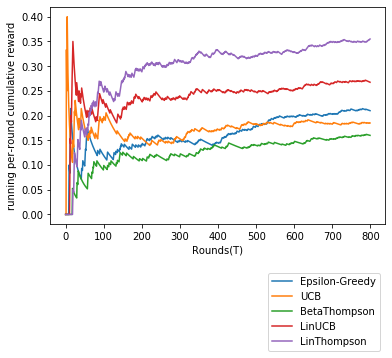

In [28]:
plt.plot(np.cumsum(results_EpsGreedy)/np.asarray(range(1,801)) , label = "Epsilon-Greedy")
plt.plot(np.cumsum(results_UCB)/np.asarray(range(1,801)), label = "UCB")
plt.plot(np.cumsum(results_BetaThompson)/np.asarray(range(1,801)), label = "BetaThompson")
plt.plot(np.cumsum(results_LinUCB)/np.asarray(range(1,801)), label = "LinUCB")
plt.plot(np.cumsum(results_LinThompson)/np.asarray(range(1,801)), label = "LinThompson")
plt.ylabel('running per-round cumulative reward')
plt.xlabel('Rounds(T)')
plt.legend(bbox_to_anchor=(1, -0.2))
plt.show()

### 6.B.

In [20]:
# manually define the grid of hyperparameters
grid = [0.01,0.02,0.05,0.08,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.5,2,3,4,5,10]
LinUCB_result = []
LinThompson_result = [] 
# run LinUCB and LinThompson for all parameters in grid
for n in grid:
    mab1 = LinUCB(10, 10, n)
    mab2 = LinThompson(10, 10, n)
    results2_LinUCB = offlineEvaluate(mab1, arms, rewards, contexts, 800)
    results2_LinThompson = offlineEvaluate(mab2, arms, rewards, contexts, 800)
    # save average reward
    LinUCB_result.append(np.mean(results2_LinUCB))
    LinThompson_result.append(np.mean(results2_LinThompson))

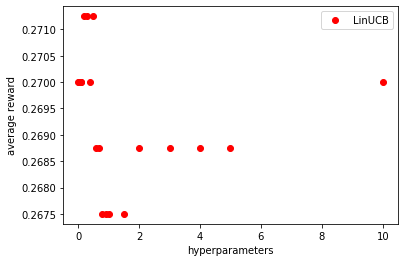

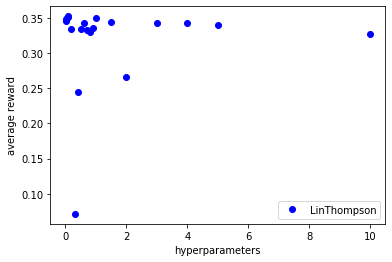

In [21]:
# plot LinUCB
plt.plot(grid,LinUCB_result, 'ro', label = "LinUCB")
plt.ylabel('average reward')
plt.xlabel('hyperparameters')
plt.legend()
plt.show()

# plot LinThompson
plt.plot(grid,LinThompson_result, 'bo', label = "LinThompson")
plt.ylabel('average reward')
plt.xlabel('hyperparameters')
plt.legend()
plt.show()